In [1]:
import xarray as xr # for data handling
import numpy as np # for maths
import matplotlib as mpl # plotlibrary
import matplotlib.pyplot as plt # for the plots 
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm # for making a log 10 colorscale
import cartopy # library for making maps
from cartopy import crs as ccrs # Projection Library
from cartopy.crs import Stereographic, PlateCarree, Mollweide # Map projections I use00
from cartopy.feature import LAND, COASTLINE # Vectordata of the Coastline and land for making the maps prettier
import cmocean
from glob import glob
import dask
from scipy.io import loadmat
import gsw

# Exercise 1

In [6]:
def deg360to180(ds, lon_dim):
    dim_name = ds[lon_dim].dims[0]
    ds["lon_new"] = xr.where(
    ds[lon_dim]>180, # take all the values, where X is less than zero
    ds[lon_dim]-360, # if true, add 360
    ds[lon_dim], # if false take them verbatim
    )
    ds = (
        ds
        .swap_dims(dict(zip([dim_name], ["lon_new"]))) # Make the new values to our dimension
        .sortby("lon_new") # make sure to sort them
        .drop_vars(lon_dim) # drop the old Dimension
        .rename(dict(zip(["lon_new"],[dim_name])))
    )#
    return ds

## Read Files

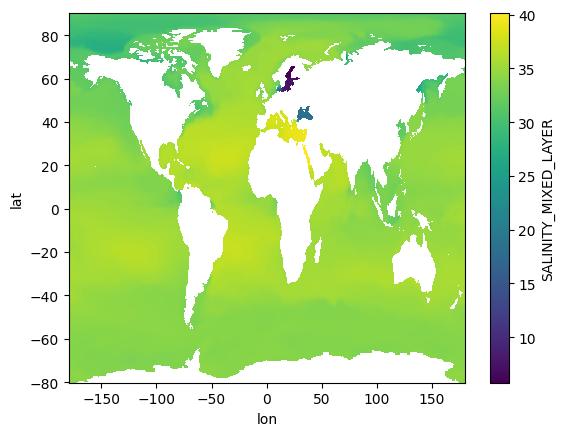

In [44]:
mimoc_files = glob("./MIMOC_ML_v2.2_PT_S/*")
mimoc = xr.open_mfdataset(mimoc_files, combine="nested", concat_dim="month", compat="no_conflicts", data_vars="different")
mimoc = mimoc.assign_coords(
    dict(
        lat=mimoc.LATITUDE,
        lon=mimoc.LONGITUDE,
    )
).swap_dims(
    dict(
        LAT="lat",
        LONG="lon",
    )
).drop_vars(("LATITUDE", "LONGITUDE")).sortby(["lon", "lat"])
mimoc = deg360to180(mimoc, "lon")
mimoc.SALINITY_MIXED_LAYER.isel(month=0).plot()

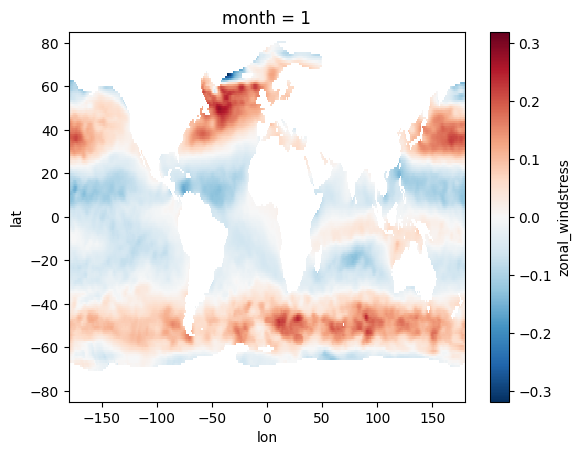

In [42]:
lats = loadmat("./atae.mat").get("lat").T[0]
lons = loadmat("./atae.mat").get("lon").T[0]
months = np.arange(1,13)
windstress = xr.Dataset(
    data_vars=dict(
        zonal_windstress=(["LAT","LONG","month"], loadmat("./atae.mat").get("atae")),
        meridional_windstress=(["LAT","LONG","month"], loadmat("./atae.mat").get("atae")),
        ),
    coords=dict(
        lat=("LAT", lats),
        lon=("LONG", lons),
        month=("month", months),
    ),
).swap_dims(dict(LAT="lat", LONG="lon")).sortby("lon")
windstress = deg360to180(windstress, "lon")
windstress.zonal_windstress.isel(month=0).plot()

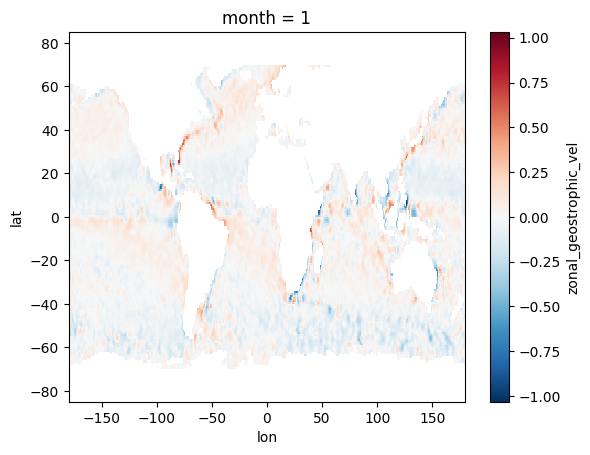

In [41]:
lats = loadmat("./Drifter_climatology.mat").get("lat").T[0]
lons = loadmat("./Drifter_climatology.mat").get("lon").T[0]
months = np.arange(1,13)
geostrophic_velocity = xr.Dataset(
    data_vars=dict(
        zonal_geostrophic_vel=(["LAT","LONG","month"], loadmat("./Drifter_climatology.mat").get("iV_g")),
        meridional_geostrophic_vel=(["LAT","LONG","month"], loadmat("./Drifter_climatology.mat").get("iU_g")),
        ),
    coords=dict(
        lat=("LAT", lats),
        lon=("LONG", lons),
        month=("month", months),
    ),
).swap_dims(dict(LAT="lat", LONG="lon")).sortby("lon")
geostrophic_velocity = deg360to180(geostrophic_velocity, "lon")
geostrophic_velocity.zonal_geostrophic_vel.isel(month=0).plot()

## Ekman Pumping

In [8]:
mimoc["conservative_temperature"] = gsw.conversions.CT_from_pt(mimoc.SALINITY_MIXED_LAYER, mimoc.POTENTIAL_TEMPERATURE_MIXED_LAYER).assign_attrs(dict(long_name="Conservative Temperatue"))
mimoc["density"] = gsw.density.rho(mimoc.SALINITY_MIXED_LAYER, mimoc.conservative_temperature, 0).assign_attrs(dict(long_name="Density"))


In [45]:
mimoc_south_atlantic = mimoc.sel(month=8, lon=slice(-60,30), lat=slice(-70, 0))
mimoc_south_atlantic

<xarray.Dataset> Size: 308kB
Dimensions:                            (lat: 141, lon: 181)
Coordinates:
  * lat                                (lat) float32 564B -70.0 -69.5 ... 0.0
  * lon                                (lon) float32 724B -60.0 -59.5 ... 30.0
Data variables:
    SALINITY_MIXED_LAYER               (lat, lon) float32 102kB dask.array<chunksize=(141, 181), meta=np.ndarray>
    POTENTIAL_TEMPERATURE_MIXED_LAYER  (lat, lon) float32 102kB dask.array<chunksize=(141, 181), meta=np.ndarray>
    DEPTH_MIXED_LAYER                  (lat, lon) float32 102kB dask.array<chunksize=(141, 181), meta=np.ndarray>

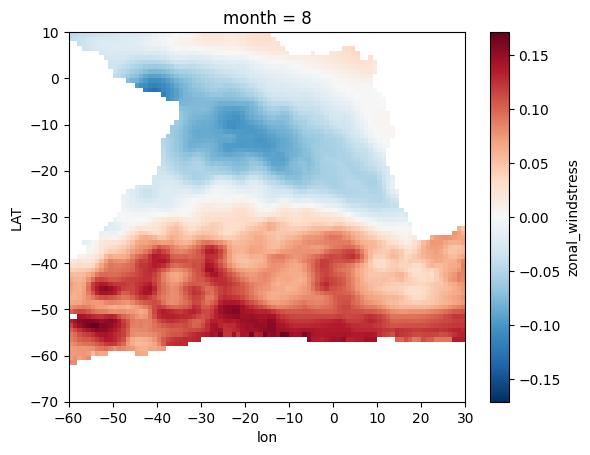

In [10]:
windstress.sel(month=8, LAT=slice(-70,10), lon=slice(-60,30)).zonal_windstress.plot()